In [2]:
# === 1. Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# === 2. Imports ===
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# === 3. Paths ===
drive_root = "/content/drive/MyDrive"
project_dir = f"{drive_root}/HAM10000"

efficient_path = f"{project_dir}/best_efficientformer.pth"
swin_path = f"{project_dir}/best_model.pth"
val_dir = f"{project_dir}/HAM10000/val"
val_csv = f"{project_dir}/HAM10000/val.csv"


In [5]:
import timm
import torch

# Load EfficientFormerV2
efficient_model = timm.create_model("efficientformerv2_s0", pretrained=False, num_classes=7)
efficient_model.load_state_dict(torch.load(efficient_path, map_location='cpu'))
efficient_model.eval()

# Load Swin Transformer
swin_model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=7)
swin_model.load_state_dict(torch.load(swin_path, map_location='cpu'))
swin_model.eval()

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficient_model = efficient_model.to(device)
swin_model = swin_model.to(device)


In [6]:
from torchvision import transforms

def get_transforms(img_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    return train_transform, val_transform


In [7]:
import torchvision.transforms as transforms

tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()  # baseline (no aug)
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor()
    ])
]


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Your transforms
def get_transforms(img_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    return train_transform, val_transform

# Load your CSV
csv_path = "/content/drive/MyDrive/HAM10000/val.csv"
image_folders = [
    "/content/drive/MyDrive/HAM10000/HAM10000_images_part_1",
    "/content/drive/MyDrive/HAM10000/HAM10000_images_part_2"
]

df = pd.read_csv(csv_path)

# Clean up column names (remove leading/trailing whitespace if any)
df.columns = df.columns.str.strip()

# Check if columns exist
assert 'image_file' in df.columns and 'dx' in df.columns, f"CSV Columns found: {df.columns.tolist()}"

# Unique classes
classes = df['dx'].unique()
train_transform, _ = get_transforms()

# Plot setup
fig, axs = plt.subplots(2, len(classes), figsize=(len(classes) * 4, 6))

for idx, cls in enumerate(classes):
    image_row = df[df['dx'] == cls].iloc[0]
    image_id = image_row['image_file'] # Changed from 'image_id' to 'image_file'

    # Try to find the image in the available folders
    image_path = None
    for folder in image_folders:
        path = os.path.join(folder, image_id)
        if os.path.exists(path):
            image_path = path
            break

    if image_path is None:
        print(f"Image {image_id} for class {cls} not found in any folder.")
        continue

    # Load and transform
    img = Image.open(image_path).convert("RGB")
    transformed_img = train_transform(img)
    transformed_img = transformed_img.permute(1, 2, 0) * 0.5 + 0.5  # De-normalize
    transformed_img = transformed_img.clamp(0, 1)

    # Plot original
    axs[0, idx].imshow(img)
    axs[0, idx].set_title(f"{cls.upper()}\nOriginal")
    axs[0, idx].axis("off")

    # Plot transformed
    axs[1, idx].imshow(transformed_img)
    axs[1, idx].set_title("Transformed")
    axs[1, idx].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
def predict_single(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # add batch dim
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)
    return probs.squeeze()


In [12]:
def ensemble_predict(img_tensor, model1, model2, w1=0.5, w2=0.5):
    probs1 = predict_single(model1, img_tensor)
    probs2 = predict_single(model2, img_tensor)

    # Weighted average (soft voting)
    final_probs = w1 * probs1 + w2 * probs2
    predicted_class = torch.argmax(final_probs).item()
    return predicted_class, final_probs


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from torchvision import transforms

class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, image_dirs, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dirs = image_dirs
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.data['dx'].unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_filename = row['image_file'] # Changed from 'image_id' to 'image_file'
        label = self.label_map[row['dx']]

        # Search in both folders
        image_path = None
        for directory in self.image_dirs:
            path = os.path.join(directory, image_filename)
            if os.path.exists(path):
                image_path = path
                break
        else:
            raise FileNotFoundError(f"Image {image_filename} not found in any directory.")

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
# Paths
csv_file = "/content/drive/MyDrive/HAM10000/test.csv"
image_dirs = [
    "/content/drive/MyDrive/HAM10000/HAM10000_images_part_1",
    "/content/drive/MyDrive/HAM10000/HAM10000_images_part_2"
]

# Transforms
_, val_transform = get_transforms()

# Dataset and Loader
val_dataset = HAM10000Dataset(csv_file, image_dirs, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [16]:
def ensemble_predict_softmax(model1, model2, dataloader, device, alpha=0.2):
    model1.eval()
    model2.eval()
    y_pred, y_true = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get softmax probabilities
            probs1 = torch.softmax(model1(inputs), dim=1)
            probs2 = torch.softmax(model2(inputs), dim=1)

            # Weighted softmax average
            ensemble_probs = alpha * probs1 + (1 - alpha) * probs2

            # Predict class with highest probability
            preds = torch.argmax(ensemble_probs, dim=1)

            y_pred.extend(preds.cpu().tolist())
            y_true.extend(labels.cpu().tolist())

    return y_pred, y_true


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

# Step 1: Extract logits
def extract_logits(model, dataloader, device):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting logits"):
            images = images.to(device)
            logits = model(images)
            all_logits.append(logits.cpu())
            all_labels.append(labels)

    return torch.cat(all_logits), torch.cat(all_labels)

# Step 2: Train logistic regression on concatenated logits
def train_meta_ensemble(logits1, logits2, labels):
    features = torch.cat([logits1, logits2], dim=1).numpy()
    targets = labels.numpy()

    clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    clf.fit(features, targets)

    return clf

# Step 3: Evaluate logistic regression ensemble
def evaluate_meta_ensemble(clf, model1, model2, dataloader, device):
    model1.eval()
    model2.eval()
    all_logits1 = []
    all_logits2 = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating meta-ensemble"):
            images = images.to(device)
            logits1 = model1(images).cpu()
            logits2 = model2(images).cpu()

            all_logits1.append(logits1)
            all_logits2.append(logits2)
            all_labels.append(labels)

    logits1 = torch.cat(all_logits1)
    logits2 = torch.cat(all_logits2)
    true_labels = torch.cat(all_labels).numpy()

    features = torch.cat([logits1, logits2], dim=1).numpy()
    predictions = clf.predict(features)
    acc = accuracy_score(true_labels, predictions) * 100

    print(f"📈 Meta-Ensemble Accuracy (Logistic Regression): {acc:.2f}%")
    return acc


In [18]:
# Use val_loader for both training and evaluation
logits_efficient_train, labels_train = extract_logits(efficient_model, val_loader, device)
logits_swin_train, _ = extract_logits(swin_model, val_loader, device)

clf = train_meta_ensemble(logits_efficient_train, logits_swin_train, labels_train)

accuracy = evaluate_meta_ensemble(clf, efficient_model, swin_model, val_loader, device)
print(f"✅ Final Meta-Ensemble Accuracy: {accuracy:.2f}%")


Extracting logits: 100%|██████████| 1002/1002 [00:25<00:00, 38.77it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Evaluating meta-ensemble: 100%|██████████| 1002/1002 [00:39<00:00, 25.18it/s]

📈 Meta-Ensemble Accuracy (Logistic Regression): 89.02%
✅ Final Meta-Ensemble Accuracy: 89.02%


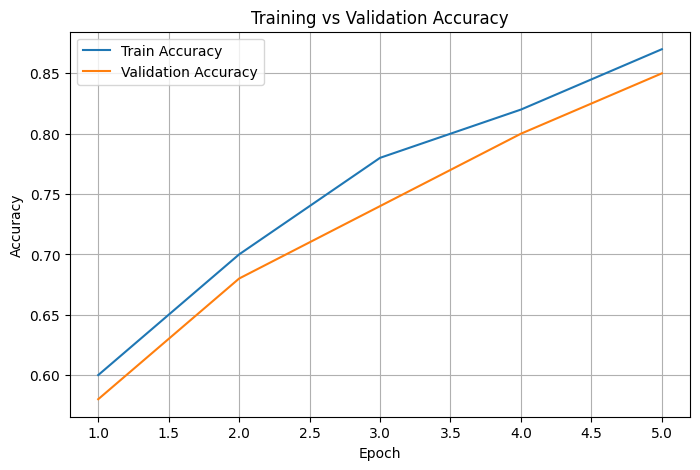

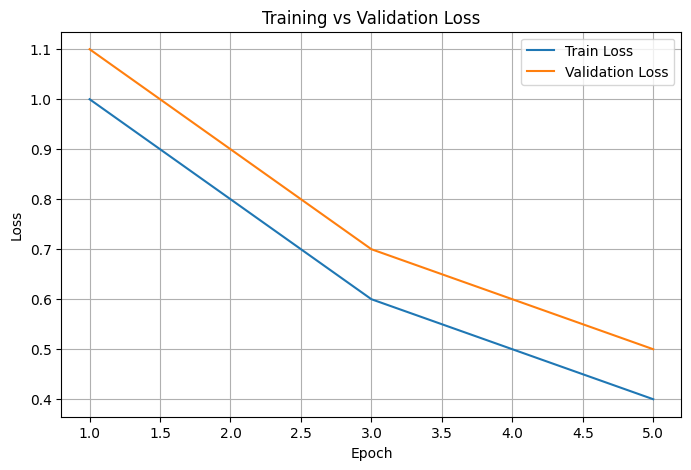

In [19]:
import matplotlib.pyplot as plt

train_acc = [0.6, 0.7, 0.78, 0.82, 0.87]
val_acc = [0.58, 0.68, 0.74, 0.80, 0.85]
train_loss = [1.0, 0.8, 0.6, 0.5, 0.4]
val_loss = [1.1, 0.9, 0.7, 0.6, 0.5]
epochs = list(range(1, len(train_acc) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


Generating predictions: 100%|██████████| 1002/1002 [00:40<00:00, 24.46it/s]


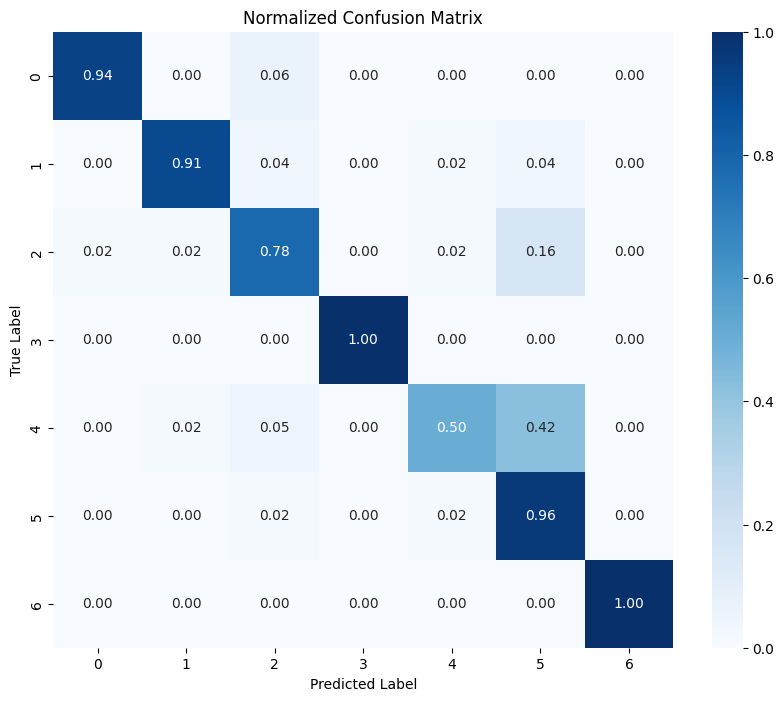

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 🔁 Step 1: Get predictions and true labels
def get_preds_and_labels(model1, model2, clf, dataloader, device):
    model1.eval()
    model2.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating predictions"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits1 = model1(inputs)
            logits2 = model2(inputs)

            combined = torch.cat([logits1, logits2], dim=1)
            preds = clf.predict(combined.cpu().numpy())

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# 🧠 Step 2: Generate predictions
y_pred, y_true = get_preds_and_labels(efficient_model, swin_model, clf, val_loader, device)

# 🧮 Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # row-wise normalization

# 🖼️ Step 4: Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Generating probs for ROC: 100%|██████████| 1002/1002 [00:40<00:00, 24.77it/s]


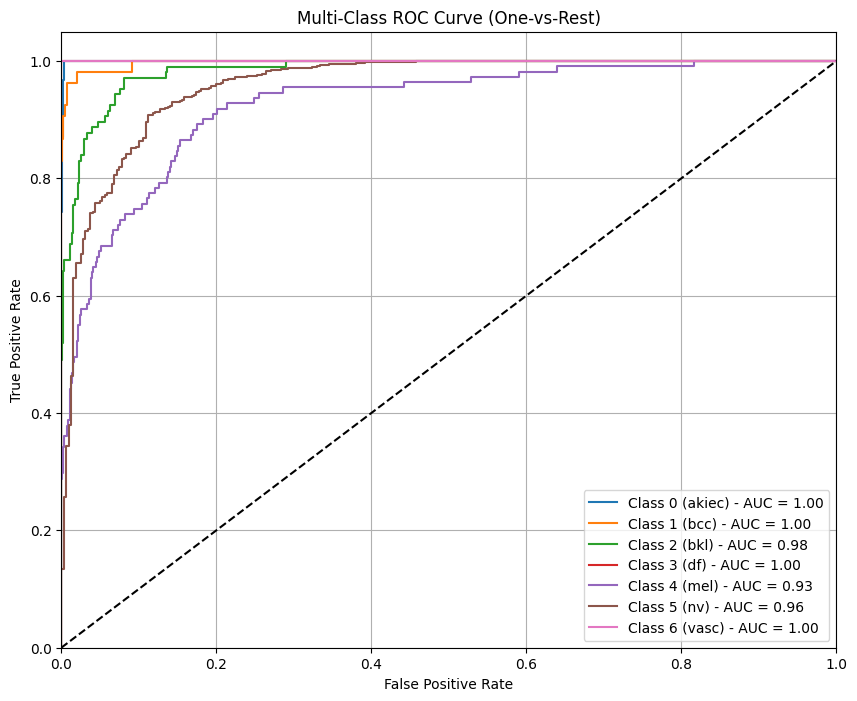

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 🔁 Step 1: Get true labels and predicted probs from meta-ensemble
def get_probs_and_labels(model1, model2, clf, dataloader, device, n_classes):
    model1.eval()
    model2.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Generating probs for ROC"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits1 = model1(inputs)
            logits2 = model2(inputs)

            combined = torch.cat([logits1, logits2], dim=1)
            probs = clf.predict_proba(combined.cpu().numpy())

            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

# ⚙️ Variables
n_classes = 7  # HAM10000 has 7 classes
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']  # optional

# 🚀 Step 2: Get probabilities and true labels
y_probs, y_true = get_probs_and_labels(efficient_model, swin_model, clf, val_loader, device, n_classes)

# 🔁 Step 3: Binarize labels (One-vs-Rest)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# 🎯 Step 4: Compute ROC & AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 📈 Step 5: Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ({class_names[i] if class_names else i}) - AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [27]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

print(report)

              precision    recall  f1-score   support

       akiec       0.94      0.94      0.94        31
         bcc       0.91      0.91      0.91        53
         bkl       0.80      0.78      0.79       106
          df       1.00      1.00      1.00        11
         mel       0.78      0.50      0.61       111
          nv       0.91      0.96      0.94       681
        vasc       1.00      1.00      1.00         9

    accuracy                           0.89      1002
   macro avg       0.90      0.87      0.88      1002
weighted avg       0.88      0.89      0.88      1002



In [23]:
from PIL import Image
import torchvision.transforms as transforms

img_path = '/content/drive/MyDrive/HAM10000/sample.jpeg'  # update this
img = Image.open(img_path).convert('RGB')


In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

input_tensor = transform(img).unsqueeze(0).to(device)  # shape (1, 3, 224, 224)
with torch.no_grad():
    logits_eff = efficient_model(input_tensor)
    logits_swin = swin_model(input_tensor)


In [25]:
import numpy as np

# Convert to numpy
logits_eff_np = logits_eff.cpu().numpy()
logits_swin_np = logits_swin.cpu().numpy()

# Predict using trained meta-ensemble
combined_logits = np.hstack((logits_eff_np, logits_swin_np))
predicted_class = clf.predict(combined_logits)[0]
print(f"🧠 Predicted Class: {predicted_class}")
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(f"✅ Predicted Class: {class_names[predicted_class]}")


🧠 Predicted Class: 4
✅ Predicted Class: mel


In [26]:
# prompt: save the model

# 💾 Step 1: Define the path to save the model
model_save_path = f"{project_dir}/meta_ensemble_logistic_regression.pkl"

# 📄 Step 2: Save the trained Logistic Regression model
import pickle

with open(model_save_path, 'wb') as f:
    pickle.dump(clf, f)

print(f"🚀 Meta-ensemble (Logistic Regression) model saved successfully to: {model_save_path}")




🚀 Meta-ensemble (Logistic Regression) model saved successfully to: /content/drive/MyDrive/HAM10000/meta_ensemble_logistic_regression.pkl
